## Keras example

**This follows Section 3.5 of https://www.manning.com/books/deep-learning-with-python**

Let's take a look at a multicategory classification task using Keras. We will be using the 
famous Reuters newswire dataset. https://archive.ics.uci.edu/ml/datasets/Reuters-21578+Text+Categorization+Collection
Here examples are short texts with their topics as labels. There are 46 different topics and we will build a topic classifier which,
given newswire text classifies its topic

### Processing data

The Reuters dataset is a classic toy dataset for text classification, included with keras. Let's load train
and test data as provided within Keras

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
print(train_data.shape)
print(test_data.shape)


(8982,)
(2246,)


Each article is encoded as a list of integers.

In [5]:
train_data[0:2]

array([list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12])],
      dtype=object)

We will use a bag-of-words encoding for text, where we represent each article by a vector of 0 or 1s, using 1s to indicate that a given word occurs in the document

In [6]:
import numpy as np

def vectorize_articles(articles, dimension=10000):
    result = np.zeros((len(articles), dimension))
    for i, article in enumerate(articles):
        result[i, article] = 1.
    return result

x_train = vectorize_articles(train_data)
x_test = vectorize_articles(test_data)

In [7]:
x_train[0,:]

array([0., 1., 1., ..., 0., 0., 0.])

Labels are currently given as integers indicating topic, we will encode them using one-hot-encoding

In [8]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [9]:
one_hot_train_labels[1,:]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Building the network

Let's build a two layer network, each layer with 64 hidden units and `relu` activation functions, and an output layer of 46 units with a `softmax` activation function
since we are doing a multicategory classification task. We use 46 units as that is the number of topics (categories) in our multi-categorical classification task.

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

With the model in place, we next need to decide how to train it. That includes deciding the loss function to use, which optimization method to use, and other metrics we may want to keep track of during training of the model. 

In [11]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

* `rmsprop`: this is an extension of gradient descent that seeks to improve convergence by scaling gradient updates by their magnitude. The GD update is divided by a running average of the gradient magnitudes in some small number of last iterations.

* `categorical_crossentropy`: a loss function used for multiclass classification tasks. Recall that the `softmax` activation function for each of the 46 output nodes is given by $f_k = \frac{e^{s_k}}{\sum_l e^{s_l}}$. We can interpret $f_k$ as the probability of classifiying an example with label $k$. Cross entropy is based on the deviation of the probability distribution given by the output layer and the observed distribution, which is 0 everywhere except for the observed label, in which case it is 1. So, letting $y_k$ be the one-hot-encoding of the observed class. The loss function (for each example) is then $-\sum_k y_k\log{f_k}$.

* We indicate we want to prediction accuracy as we train the network

### Training network

Now we are ready to train the network. First we grab a validation set of 1000 examples to measure validation loss and accuracy and decide how many epochs to train the model to avoid overfitting.

In [12]:
x_val = x_train[:1000]
partial_train_x = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_train_y = one_hot_train_labels[1000:]

Now train the model

In [13]:
history = model.fit(partial_train_x, partial_train_y,
                   epochs=20, batch_size=512,
                   validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 106us/step - loss: 2.6752 - acc: 0.4851 - val_loss: 1.7585 - val_acc: 0.6100
Epoch 2/20
7982/7982 [==============================] - 1s 67us/step - loss: 1.4370 - acc: 0.6901 - val_loss: 1.2963 - val_acc: 0.7120
Epoch 3/20
7982/7982 [==============================] - 1s 65us/step - loss: 1.0536 - acc: 0.7699 - val_loss: 1.1248 - val_acc: 0.7590
Epoch 4/20
7982/7982 [==============================] - 1s 63us/step - loss: 0.8363 - acc: 0.8231 - val_loss: 1.0229 - val_acc: 0.7720
Epoch 5/20
7982/7982 [==============================] - 1s 64us/step - loss: 0.6721 - acc: 0.8601 - val_loss: 0.9607 - val_acc: 0.7880
Epoch 6/20
7982/7982 [==============================] - 1s 68us/step - loss: 0.5427 - acc: 0.8893 - val_loss: 0.9062 - val_acc: 0.8160
Epoch 7/20
7982/7982 [==============================] - 1s 64us/step - loss: 0.4451 - acc: 0.9093 - val_loss: 0.8884 - val_acc: 0.8070
Epoch 

Let's take a look at loss and accuracy curves across epochs. First loss

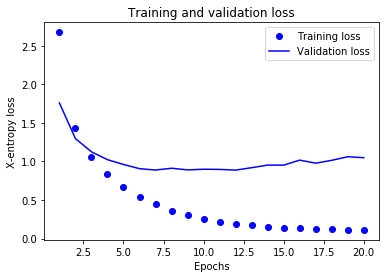

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('X-entropy loss')
plt.legend()
plt.show()

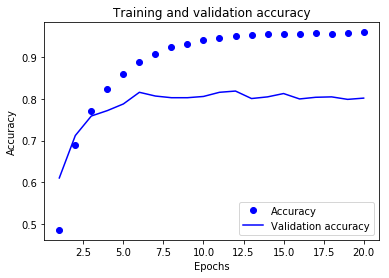

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label="Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Let's retrain the model to up to 8 epochs since it's overfitting after that many

In [16]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_train_x, partial_train_y,
                   epochs=8, batch_size=512,
                   validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 63us/step - loss: 2.6182 - acc: 0.5348 - val_loss: 1.7247 - val_acc: 0.6490
Epoch 2/8
7982/7982 [==============================] - 1s 64us/step - loss: 1.4110 - acc: 0.7041 - val_loss: 1.2857 - val_acc: 0.7110
Epoch 3/8
7982/7982 [==============================] - 1s 63us/step - loss: 1.0425 - acc: 0.7707 - val_loss: 1.1305 - val_acc: 0.7500
Epoch 4/8
7982/7982 [==============================] - 1s 63us/step - loss: 0.8245 - acc: 0.8231 - val_loss: 1.0384 - val_acc: 0.7640
Epoch 5/8
7982/7982 [==============================] - 1s 65us/step - loss: 0.6627 - acc: 0.8604 - val_loss: 0.9664 - val_acc: 0.7920
Epoch 6/8
7982/7982 [==============================] - 1s 69us/step - loss: 0.5308 - acc: 0.8890 - val_loss: 0.9052 - val_acc: 0.8080
Epoch 7/8
7982/7982 [==============================] - 1s 70us/step - loss: 0.4292 - acc: 0.9098 - val_loss: 0.8908 - val_acc: 0.8110
Epoch 8/8
7982

Let's evaluate the results on the test set

In [17]:
model.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 0s 98us/step


[0.9603412936865381, 0.7849510240427426]

Since we are using a `softmax` activation function, we can generate "class probabilities" as predictions (we could do this with decision trees and ensemble methods).

In [18]:
predictions = model.predict(x_test)
predictions[0]

array([7.6900695e-05, 4.2935822e-05, 3.2781343e-05, 8.5211480e-01,
       1.3569129e-01, 5.3402828e-06, 1.6671572e-04, 9.3534822e-05,
       3.2605592e-03, 8.5922593e-04, 2.7447652e-05, 4.2492140e-04,
       2.7797509e-05, 8.7930370e-05, 4.5979537e-05, 3.3149703e-05,
       4.4370015e-04, 1.2646876e-04, 7.7520395e-05, 2.8847915e-04,
       2.4808361e-03, 5.5713061e-04, 8.5781030e-06, 1.7928799e-04,
       2.7332668e-05, 3.6474379e-05, 1.9695526e-05, 1.7945906e-04,
       4.7047179e-06, 2.6655020e-04, 1.6466871e-05, 3.8738915e-04,
       7.9197547e-05, 1.1676003e-05, 5.6642835e-04, 3.8697279e-05,
       8.7120919e-04, 4.9861505e-05, 2.9715569e-05, 9.2106930e-05,
       2.9618865e-05, 1.1342183e-05, 1.8259194e-05, 1.0247576e-04,
       3.1814684e-06, 4.8566412e-06], dtype=float32)

Let's see what that article is

In [20]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
' '.join([reverse_word_index.get(i-3, '?') for i in test_data[0]])

'? the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to ? growth and expansion plans for ? inc and ? inc over the next two years a and p said the acquisition of ? in august 1986 and ? in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt ? ? of west germany reuter 3'

### Mis-specifying architecture

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_train_x, partial_train_y,
                   epochs=20, batch_size=512,
                   validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 65us/step - loss: 3.0528 - acc: 0.4461 - val_loss: 2.3319 - val_acc: 0.6030
Epoch 2/20
7982/7982 [==============================] - 1s 64us/step - loss: 1.9118 - acc: 0.6570 - val_loss: 1.7087 - val_acc: 0.6490
Epoch 3/20
7982/7982 [==============================] - 1s 64us/step - loss: 1.4177 - acc: 0.7067 - val_loss: 1.4356 - val_acc: 0.6930
Epoch 4/20
7982/7982 [==============================] - 1s 66us/step - loss: 1.1645 - acc: 0.7420 - val_loss: 1.2991 - val_acc: 0.7110
Epoch 5/20
7982/7982 [==============================] - 1s 67us/step - loss: 0.9905 - acc: 0.7770 - val_loss: 1.2293 - val_acc: 0.7220
Epoch 6/20
7982/7982 [==============================] - 1s 66us/step - loss: 0.8548 - acc: 0.8093 - val_loss: 1.1475 - val_acc: 0.7520
Epoch 7/20
7982/7982 [==============================] - 1s 71us/step - loss: 0.7372 - acc: 0.8375 - val_loss: 1.1077 - val_acc: 0.7570
Epoch 8

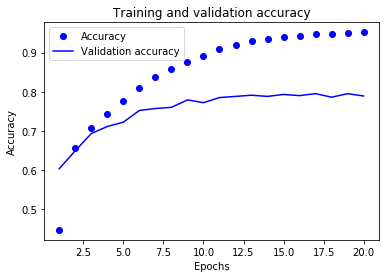

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label="Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()